# Predecting product healthiness

we will use the open food fact database to predict if a product is 'healthy' or not.
Learn more about the data : https://fr.openfoodfacts.org/

* first step : pre-process the data (reading, cleaning)
* second step : expolaroty data analysis
* third step : feature selection
* fourth step : building the predictive model based on random forest algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\bbbbb\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df=pd.read_csv('en.openfoodfacts.org.products.csv',sep='\t', low_memory=False)

In [3]:
#to access a cell of df [index,column]
print(df.iat[0,1])
#or iloc[index,column]
print(df.iloc[0][1])
#or we slice by columns and the get the element by its index from the column
print(df['url'][0])
print(df.shape)
df.head()

http://world-en.openfoodfacts.org/product/10/madeleines-nature-bijou
http://world-en.openfoodfacts.org/product/10/madeleines-nature-bijou
http://world-en.openfoodfacts.org/product/10/madeleines-nature-bijou
(505170, 173)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,10.0,http://world-en.openfoodfacts.org/product/10/m...,jeanbono,1476947941,2016-10-20T07:19:01Z,1476954879,2016-10-20T09:14:39Z,Madeleines nature,NaN,880 g,...,NaN,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,http://world-en.openfoodfacts.org/product/11,date-limite-app,1481416371,2016-12-11T00:32:51Z,1481416371,2016-12-11T00:32:51Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24.0,http://world-en.openfoodfacts.org/product/24/1...,allfitnessfactory-de,1484289130,2017-01-13T06:32:10Z,1490373603,2017-03-24T16:40:03Z,100% Soja Protein Vanille,100% Soja Protein Vanille Geschmack,2 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30.0,http://world-en.openfoodfacts.org/product/30/c...,beniben,1481840144,2016-12-15T22:15:44Z,1481840644,2016-12-15T22:24:04Z,Cakes Raisins,Pâtisseries aux raisins secs.,900 g,...,NaN,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31.0,http://world-en.openfoodfacts.org/product/31/c...,beniben,1468014954,2016-07-08T21:55:54Z,1471551390,2016-08-18T20:16:30Z,Cakes aux Fruits,Pâtisseries aux fruits confits et aux raisins ...,600 g,...,NaN,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#lets begin cleaning the data
print(df.columns)
print(df['nutrition_grade_fr'].value_counts().shape)

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=173)
(5,)


In [5]:
#now lets delete all the columns with no value entered
for column in df.columns:
    if (len(df[str(column)].value_counts())<2):
        #axis : int or axis name :Whether to drop labels from the index (0 / ‘index’) or columns (1 / ‘columns’).
        df.drop([str(column)],inplace=True,axis=1)

In [6]:
df.shape

(505170, 151)

In [7]:
#lets get ride of these unuseful variables
df.drop(['url','creator','created_t','created_datetime',
        'last_modified_datetime','generic_name',
        'image_small_url','image_url','main_category',
        'states_tags','states','additives_tags',
        'traces_tags','last_modified_t','packaging_tags',
        'brands_tags','categories_tags','categories',
        'origins_tags','manufacturing_places_tags','labels',
        'labels_tags','emb_codes_tags','countries_tags',
        'countries','traces'],axis=1,inplace=True)

In [8]:
#lets look up for the categorical data
#we have 35 categorical variable
print(df[df.columns[df.dtypes=='object']].shape)
#displaying them all
def describe_categorical(X):
    from IPython.display import display,HTML
    display(HTML(X[X.columns[X.dtypes=='object']].describe().to_html()))

describe_categorical(df)

(505170, 35)


,product_name,quantity,packaging,brands,categories_en,origins,manufacturing_places,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_en,ingredients_text,allergens,allergens_en,traces_en,serving_size,serving_quantity,additives,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_en,main_category_en,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url
count,487656,142576,106611,419100,134376,29582,49546,83731,35899,22870,24594,77358,62815,504820,366854,55040,21,34580,222509,494051,366806,205979,366827,10780,366827,20297,104909,215107,219729,505116,134347,53497,53497,44646,44646
unique,357970,18237,19179,88520,30182,5838,9336,19687,10087,1843,2943,6502,4043,809,319481,23570,21,4521,26215,1523,307990,49230,5,16,8,245,5,14,42,1102,4451,53496,53496,44646,44646
top,Ice Cream,500 g,"sachet,plastique",Auchan,"Beverages,Non-sugared beverages",France,France,Organic,EMB 56251E,"47.633333,-2.666667",theix-morbihan-france,France,Carrefour,France,"Carbonated water, natural flavor.",blé,https://static.openfoodfacts.org/images/produc...,Nuts,240 ml (8 fl oz),0,[ extra-virgin-olive-oil -> en:extra-virgin-o...,E330 - Citric acid,0,huile-de-palme,0,e471-mono-et-diglycerides-d-acides-gras-alimen...,d,unknown,unknown,"To be completed,Nutrition facts completed,Ingr...",Plant-based foods and beverages,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...
freq,411,6032,2980,5065,6218,7761,13992,16980,236,309,298,20504,6823,265285,222,1748,1,3200,5495,281850,398,11044,356047,10299,346528,5707,29633,105470,105470,167967,28320,2,2,1,1


Lets target the categorical variables with the less unique value and convert them to a group of continuous variables using one hot encoding

We will pick 'nutrition_grade_fr' that takes 5 values and convert it 


In [9]:
df['nutrition_grade_fr'].fillna("Missing",inplace=True)
#create dummies with one hot encoding
dummies=pd.get_dummies(df['nutrition_grade_fr'],prefix='nutrition_grade_fr')
#add the new columns to the dataframe (concat on axis=1 ie columns)
df=pd.concat([df,dummies],axis=1)

In [10]:
df.shape

(505170, 131)

In [20]:
#we will save the product name as we are going to use it later
product_name=df['product_name']
#and we are going to delete the rest of the categorical data
#'cities',
df.drop(['code','product_name','quantity','packaging',
        'brands','categories_en','origins',
        'manufacturing_places','labels_en','emb_codes',
        'first_packaging_code_geo','cities_tags',
        'purchase_places','stores','countries_en',
        'ingredients_text','allergens','allergens_en',
        'traces_en','serving_size','additives','additives_en',
        'ingredients_from_palm_oil_tags','ingredients_that_may_be_from_palm_oil_tags'
        ],axis=1,inplace=True)

In [21]:
df.shape

(505170, 107)

### Exploratoring Data Analysis

Considering that suggar, caffeine and saturated fat are not good we will focus our full EDA on them

### sugars_100g analysis

In [34]:
print(df[df['sugars_100g'].isnull()].shape)
print(df['sugars_100g'].isnull().value_counts())
df['sugars_100g'].describe()

(74732, 107)
False    430438
True      74732
Name: sugars_100g, dtype: int64


count    430438.000000
mean         15.228578
std          21.571347
min         -17.860000
25%           1.000000
50%           4.760000
75%          22.860000
max        3520.000000
Name: sugars_100g, dtype: float64

There are 74732 missing values of sugars_100g

In [80]:
#returns (amout of sugar, frequency)
df['sugars_100g'].value_counts().sort_index()

-1.786000e+01        1
-6.670000e+00        1
-6.250000e+00        1
-3.570000e+00        1
-1.200000e+00        1
-8.000000e-01        1
-1.000000e-01        1
 0.000000e+00    58225
 1.000000e-27        1
 1.000000e-23        1
 1.000000e-12        1
 1.000000e-10        1
 1.000000e-07        1
 1.000000e-06        4
 1.000000e-05        1
 1.000000e-04       43
 5.000000e-04        1
 1.000000e-03      119
 1.900000e-03        1
 2.000000e-03        1
 4.000000e-03        2
 4.800000e-03        1
 5.000000e-03        7
 7.000000e-03        1
 8.000000e-03        1
 9.000000e-03        1
 1.000000e-02      472
 1.080000e-02        1
 1.200000e-02        1
 1.400000e-02        1
                 ...  
 9.830000e+01        4
 9.833000e+01        1
 9.840000e+01        4
 9.850000e+01       13
 9.860000e+01        6
 9.870000e+01        6
 9.877000e+01        1
 9.880000e+01        7
 9.882000e+01        1
 9.890000e+01        2
 9.894000e+01        2
 9.900000e+01      113
 9.910000e+

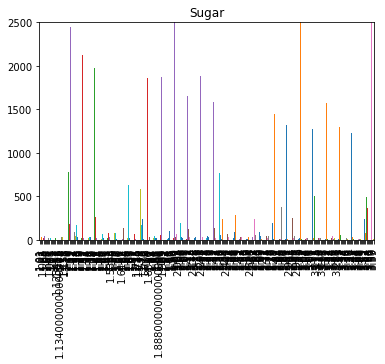

In [86]:
df['sugars_100g'][(df['sugars_100g']>1) & (df['sugars_100g']<3.6)].value_counts().sort_index().plot(kind='bar', title='Sugar')
axes = plt.gca()
#axes.set_xlim([0,400])
axes.set_ylim([0,2500])
plt.show()

### Saturated-fat_100g analysis

In [54]:
df['saturated-fat_100g'].value_counts().sort_index()

0.0000     99563
0.1000     17630
0.5000      7653
0.2000      7435
1.0000      7081
0.3000      6607
0.4000      5492
2.0000      4169
0.6000      3914
0.8000      3688
0.7000      3663
20.0000     3648
3.5700      3490
10.0000     3438
5.0000      3307
0.9000      3126
15.0000     3037
2.5000      2979
3.0000      2955
7.1400      2881
1.5000      2850
1.2000      2774
12.0000     2636
1.1000      2617
11.0000     2590
14.0000     2512
1.3000      2471
1.4000      2412
13.0000     2404
4.0000      2378
           ...  
12.4700        1
48.7000        1
37.3500        1
41.3000        1
19.4700        1
30.6400        1
0.0365         1
18.6500        1
19.9300        1
18.4400        1
0.1650         1
0.9330         1
54.5000        1
19.1800        1
10.1800        1
10.0700        1
89.3000        1
26.9700        1
20.0400        1
35.7000        1
0.2720         1
0.2880         1
1.9560         1
15.9200        1
0.2270         1
51.2000        1
11.3700        1
12.0300       

In [55]:
print(df['saturated-fat_100g'].isnull().value_counts())


False    415240
True      89930
Name: saturated-fat_100g, dtype: int64


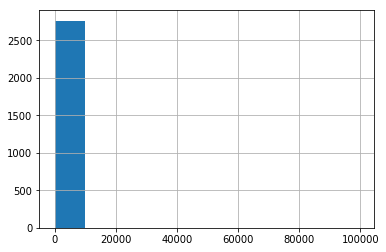

In [85]:
df['saturated-fat_100g'].value_counts().sort_index().hist() 

### Caffeine_100g analysis

In [79]:
df['caffeine_100g'].value_counts().sort_index()

0.00000     10
0.00300      1
0.00400      1
0.00450      1
0.00783      1
0.00958      2
0.00970      1
0.01000      1
0.01070      1
0.01200      2
0.01300      1
0.01500      1
0.01520      1
0.01600      1
0.01700      2
0.01800      4
0.01850      1
0.01900      2
0.02000     11
0.02100      5
0.02500      1
0.02700      1
0.02800      1
0.02900      1
0.03000      4
0.03100      2
0.03190      1
0.03200     16
0.03300      1
0.03330      2
0.03400      1
0.03477      1
0.03500      1
0.03600      2
0.03800      1
0.04000      2
0.04100      1
0.04400      2
0.04700      1
0.05000      1
0.05200      1
0.05210      1
0.06200      2
0.06300      1
0.08000      1
0.09000      1
0.10000      1
0.14700      1
0.25000      2
0.80000      2
1.00000      1
1.25000      1
2.80000      1
4.00000      4
5.88200      1
8.42000      1
20.00000     2
33.30000     1
42.28000     1
Name: caffeine_100g, dtype: int64

In [75]:
list=df['caffeine_100g'].value_counts(ascending=True)

In [76]:
list=df['caffeine_100g'].value_counts().sort_index()

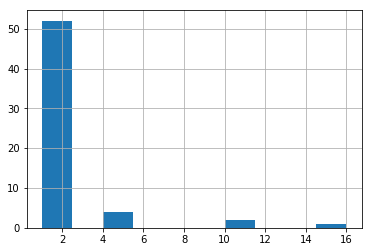

In [87]:
df['caffeine_100g'].value_counts().sort_index().hist() 

In [88]:
#we will assume that products with NaN caffeine value don't have it at all
df['caffeine_100g'].fillna(0,inplace=True)

### Handling missing values

In [89]:
df[df['caffeine_100g'].isnull()]

,serving_quantity,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states_en,main_category_en,...,choline_100g,beta-glucan_100g,inositol_100g,carnitine_100g,nutrition_grade_fr_Missing,nutrition_grade_fr_a,nutrition_grade_fr_b,nutrition_grade_fr_c,nutrition_grade_fr_d,nutrition_grade_fr_e


## Feature selection

In [95]:
#we create a quick model to pick the feature that are valuable to our prediction
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=42)


In [101]:
#we drop the remaining 'object' columns to clean the data
df.drop(['image_nutrition_small_url','image_nutrition_url',
         'image_ingredients_small_url','image_ingredients_url','main_category_en',
        'states_en','pnns_groups_2','pnns_groups_1',
        'nutrition_grade_fr','ingredients_that_may_be_from_palm_oil_n','ingredients_from_palm_oil_n',
        'serving_quantity'],axis=1,inplace=True)
df.columns


Index(['no_nutriments', 'additives_n', 'energy_100g', 'energy-from-fat_100g',
       'fat_100g', 'saturated-fat_100g', '-capric-acid_100g',
       '-lauric-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
       '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g',
       'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g',
       '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g',
       'omega-9-fat_100g', '-oleic-acid_100g', '-gondoic-acid_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g',
       '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g',
       'polyols_100g', 'fiber_100g', 'proteins_100g', 'casein_100g',
       'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g',
       'alco

In [103]:
#We make sure that all is set up to build the model
def describe(X):
    from IPython.display import display,HTML
    display(HTML(X[X.columns[X.dtypes!='object']].describe().to_html()))
describe(df)

,no_nutriments,additives_n,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-capric-acid_100g,-lauric-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,choline_100g,beta-glucan_100g,inositol_100g,carnitine_100g,nutrition_grade_fr_Missing,nutrition_grade_fr_a,nutrition_grade_fr_b,nutrition_grade_fr_c,nutrition_grade_fr_d,nutrition_grade_fr_e
count,27.000000,366827.000000,446104.000000,888.000000,438449.000000,415240.000000,2.000000,4.000000,28.000000,27.000000,23270.000000,23310.000000,1059.000000,254.000000,59.000000,106.000000,218.000000,171.000000,9.000000,30.000000,28.000000,27.000000,17.000000,1.600000e+01,143619.000000,144270.000000,438297.000000,430438.000000,98.00000,35.000000,46.000000,318.000000,6.00000,12.000000,323.000000,540.000000,2.623270e+05,444951.000000,32.000000,18.000000,9.000000,429501.000000,429461.000000,5459.000000,137870.000000,41.000000,7395.000000,1612.000000,949.000000,141264.000000,11416.000000,11030.000000,11938.000000,7044.000000,5415.000000,3059.000000,5.540000e+03,357.000000,2635.000000,86.000000,149.000000,25021.000000,267.000000,142097.000000,6040.000000,140915.000000,6586.000000,4022.000000,2157.000000,1664.000000,131.000000,1208.000000,28.000000,30.000000,340.000000,505170.000000,36.000000,94.000000,3090.000000,3465.000000,227.000000,2673.000000,288.000000,104909.000000,104909.000000,27.000000,6.000000,24.000000,12.000000,505170.000000,505170.000000,505170.000000,505170.000000,505170.000000,505170.000000
mean,310.155556,1.696167,1133.481832,570.565417,13.100619,5.161774,6.040000,36.136182,10.473714,10.348148,10.593912,6.454788,3.823114,1.768059,2.168619,2.703463,17.114583,18.421480,0.051344,0.313740,0.217840,40.677037,28.458824,1.343750e-06,0.073391,0.020449,30.191992,15.228578,13.60102,3.286286,21.273043,5.439726,17.10000,11.333333,29.438947,51.236039,2.124028e+04,7.587968,4.105313,2.283333,0.021678,1.788086,0.704035,8.661892,0.000960,0.452987,0.000011,0.054308,0.033183,0.024625,0.356796,0.254087,0.020092,0.177430,0.006721,0.204712,6.478673e-04,0.000211,0.068708,0.408324,0.337949,0.442770,0.080909,0.129427,0.637218,0.003857,0.539472,0.011809,0.025691,0.002461,0.007854,0.004283,0.001217,0.200156,0.038752,0.000308,11.297717,6.585699,36.222653,45.598308,15.215859,47.448279,313.420506,9.221420,8.426627,0.066504,4.133333,0.032813,0.008100,0.792329,0.030107,0.029117,0.041564,0.058659,0.048223
std,113.449648,2.381840,886.936890,701.807546,17.465253,8.000331,0.226274,24.101433,3.896346,3.351850,17.027925,14.866015,16.909373,6.973141,11.210742,12.813870,31.426464,136.012196,0.029298,0.776526,0.819698,25.347607,24.841987,4.643544e-07,1.537807,0.370842,29.075538,21.571347,15.23159,6.104543,26.240492,13.207251,17.80719,8.484889,24.42

In [118]:
#we drop the variables we are going to predict
df_train=df.drop(['nutrition_grade_fr_e','nutrition_grade_fr_d',
                 'nutrition_grade_fr_c','nutrition_grade_fr_b',
                 'nutrition_grade_fr_a','nutrition_grade_fr_Missing',
                 'nutrition-score-uk_100g','nutrition-score-fr_100g'],axis=1,inplace=False)
df_train.fillna(0,inplace=True)
model.fit(df_train[:1000],dummies[:1000])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

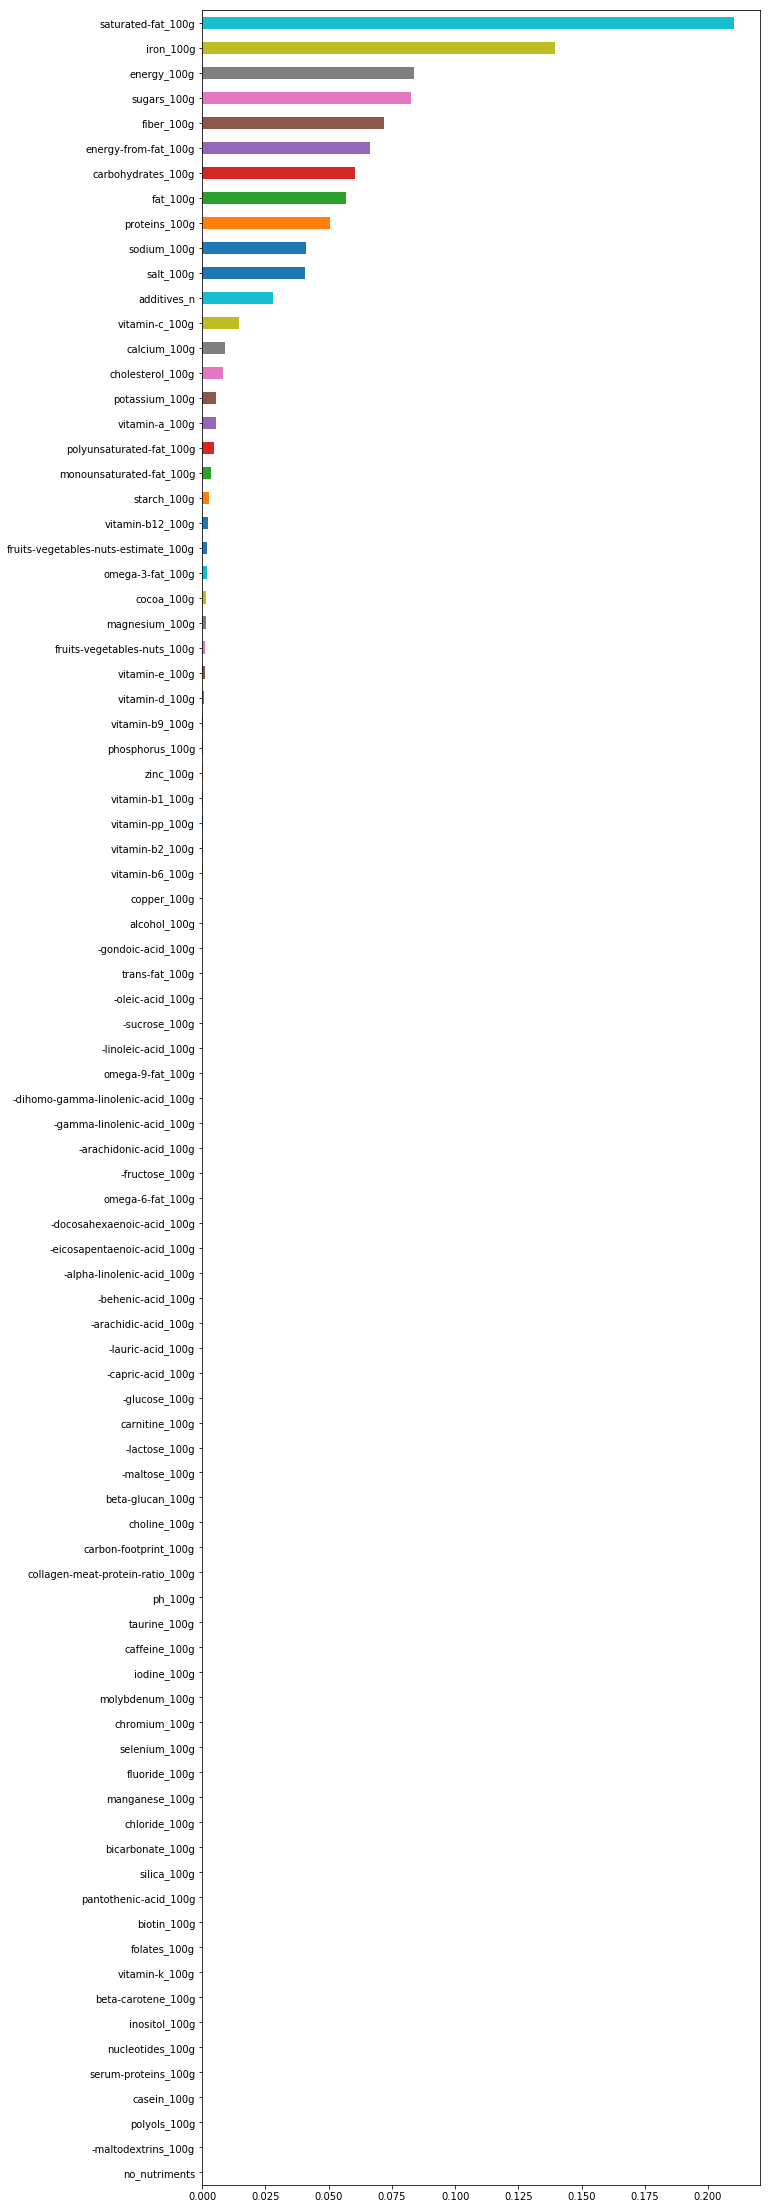

In [128]:
#We measure the importance of each feature
feature_importances=pd.Series(model.feature_importances_,index=df_train.columns)
feature_importances.sort_values(inplace=True)
plt.figure(figsize=(10,40))
feature_importances.plot(kind='barh')
plt.savefig('feature_importance_food_facts.png')


As we can see, we can pick the 11 first variables and be pretty sure that our model will be as efficient ass with all the variables

## Building the model

In [136]:
#Lets now build the model based on the variables we got from the feature selection process
feature_importances.sort_values(inplace=True,ascending=False)

feature_importances[:11]

saturated-fat_100g      0.210125
iron_100g               0.139314
energy_100g             0.083786
sugars_100g             0.082527
fiber_100g              0.072079
energy-from-fat_100g    0.066417
carbohydrates_100g      0.060607
fat_100g                0.057051
proteins_100g           0.050371
sodium_100g             0.041076
salt_100g               0.040529
dtype: float64

In [163]:
#build test and training sets
from sklearn.cross_validation import train_test_split

df_train_food_fact=df[['saturated-fat_100g','iron_100g','energy_100g','sugars_100g','fiber_100g','energy-from-fat_100g','carbohydrates_100g','fat_100g','proteins_100g','sodium_100g','salt_100g']]
df_train_food_fact.fillna(0,inplace=True)

X_train,X_test,y_train,y_test=train_test_split(df_train_food_fact[:10000],dummies[:10000],test_size=0.2,random_state=42)

print(X_train.shape, ' ', X_test.shape)
print(y_train.shape, ' ', y_test.shape)

(8000, 11)   (2000, 11)
(8000, 6)   (2000, 6)


C:\Users\bbbbb\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [158]:

modelFoodFact=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=42)
modelFoodFact.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [196]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

y_ = y_test.idxmax(axis=1)
y_.replace(to_replace='nutrition_grade_fr_Missing', value=0,inplace=True)
y_.replace(to_replace='nutrition_grade_fr_e', value=5,inplace=True)
y_.replace(to_replace='nutrition_grade_fr_d', value=4,inplace=True)
y_.replace(to_replace='nutrition_grade_fr_c', value=3,inplace=True)
y_.replace(to_replace='nutrition_grade_fr_b', value=2,inplace=True)
y_.replace(to_replace='nutrition_grade_fr_a', value=1,inplace=True)

y_real=modelFoodFact.predict(X_test)
print(y_.value_counts())
print(pd.DataFrame(y_real).idxmax(axis=1).value_counts())
print(classification_report(y_,pd.DataFrame(y_real).idxmax(axis=1)))


0    1831
4      44
5      37
1      36
2      28
3      24
dtype: int64
0    1883
4      38
5      24
1      24
2      17
3      14
dtype: int64
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1831
          1       0.75      0.50      0.60        36
          2       0.47      0.29      0.36        28
          3       0.57      0.33      0.42        24
          4       0.71      0.61      0.66        44
          5       0.62      0.41      0.49        37

avg / total       0.93      0.94      0.94      2000

